In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

local_zip = '/content/drive/MyDrive/MFCC numpy 20k bee dataset.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [16]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

TRAINING_DIR = "/tmp/MFCC numpy 20k bee dataset/train"
VALIDATION_DIR = "/tmp/MFCC numpy 20k bee dataset/val"
TEST_DIR = "/tmp/MFCC numpy 20k bee dataset/test"

def load_data(directory):
    sc_features = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            if not os.path.isfile(file_path):
                continue
            sc = np.load(file_path)
            sc_features.append(sc)
            labels.append(label)
    return sc_features, labels

train_sc_features, train_labels = load_data(TRAINING_DIR)
val_sc_features, val_labels = load_data(VALIDATION_DIR)
test_sc_features, test_labels = load_data(TEST_DIR)

In [9]:
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

X_train = np.array(train_sc_features)
y_train = np.array(encoded_train_labels)

X_val = np.array(val_sc_features)
y_val = np.array(encoded_val_labels)

X_test = np.array(test_sc_features)
y_test = np.array(encoded_test_labels)


In [10]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

In [11]:
def get_stacking():
    level0 = list()
    level0.append(('rf', RandomForestClassifier(random_state=1337)))
    level0.append(('et', ExtraTreesClassifier(random_state=1337)))
    level0.append(('xgb', xgb.XGBClassifier(random_state=1337)))
    level1 = RandomForestClassifier(random_state=1337)

    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [13]:
import time

t1=time.time()

model = get_stacking()
score = evaluate_model(model, X_train_normalized, y_train)

t2=time.time()
print(t2-t1,'s')
print(score)

2027.867371559143 s
[0.94357143 0.94071429 0.935      0.94142857 0.94071429 0.94428571
 0.94214286 0.94071429 0.94428571 0.93857143 0.93928571 0.93785714
 0.92642857 0.92928571 0.94642857 0.93142857 0.935      0.94214286
 0.94428571 0.94       0.93142857 0.94785714 0.94428571 0.93357143
 0.93714286 0.93785714 0.94285714 0.93571429 0.93857143 0.93285714]


In [14]:
model = get_stacking()

t3=time.time()
model.fit(X_train_normalized, y_train)
t4=time.time()
print(t4-t3,'s')

y_pred = model.predict(X_test_normalized)
accuracy = model.score(X_test_normalized, y_test)
print("Test Accuracy:", accuracy)

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

90.66400837898254 s
Test Accuracy: 0.93975
Classification Report:
               precision    recall  f1-score   support

       Queen       0.94      0.94      0.94      2000
   Queenless       0.94      0.94      0.94      2000

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



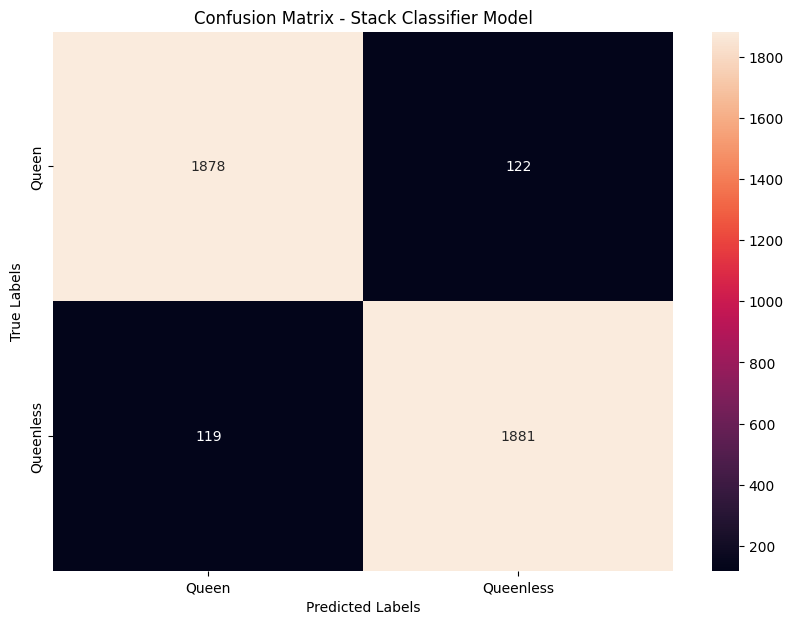

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = label_encoder.classes_
confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt="", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Stack Classifier Model')
plt.show()

In [22]:
import pickle

with open('40_mfccs_stack.pkl', 'wb') as f:
    pickle.dump(model, f)